In [ ]:
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user
!jupyter nbextension enable --py widgetsnbextension && jupyter nbextension enable --py --sys-prefix widgetsnbextension && jupyter nbextension enable --py autocomplete

In [ ]:
!pip install tensorflow-addons 

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import *
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 4
SHAPE = (256, 256, 3)

# 1.DATA

### Loading the Dataset

In [ ]:
!tar -zxvf {'VanGogh2Photo.tar.gz'}

In [6]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (256, 256))
    return (img-127.5)/127.5

In [7]:
photo_list = tf.data.Dataset.list_files('Dataset/Photo/*.jpg')
ukiyoe_list = tf.data.Dataset.list_files('Dataset/Style/*.jpg')

In [8]:
photo_ds = photo_list.map(load_img)
ukiyoe_ds = ukiyoe_list.map(load_img)

dataset = tf.data.Dataset.zip((photo_ds, ukiyoe_ds)).cache().shuffle(10000).batch(BATCH_SIZE)

In [9]:
len(dataset)

1550

In [10]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

### Testing the Dataset

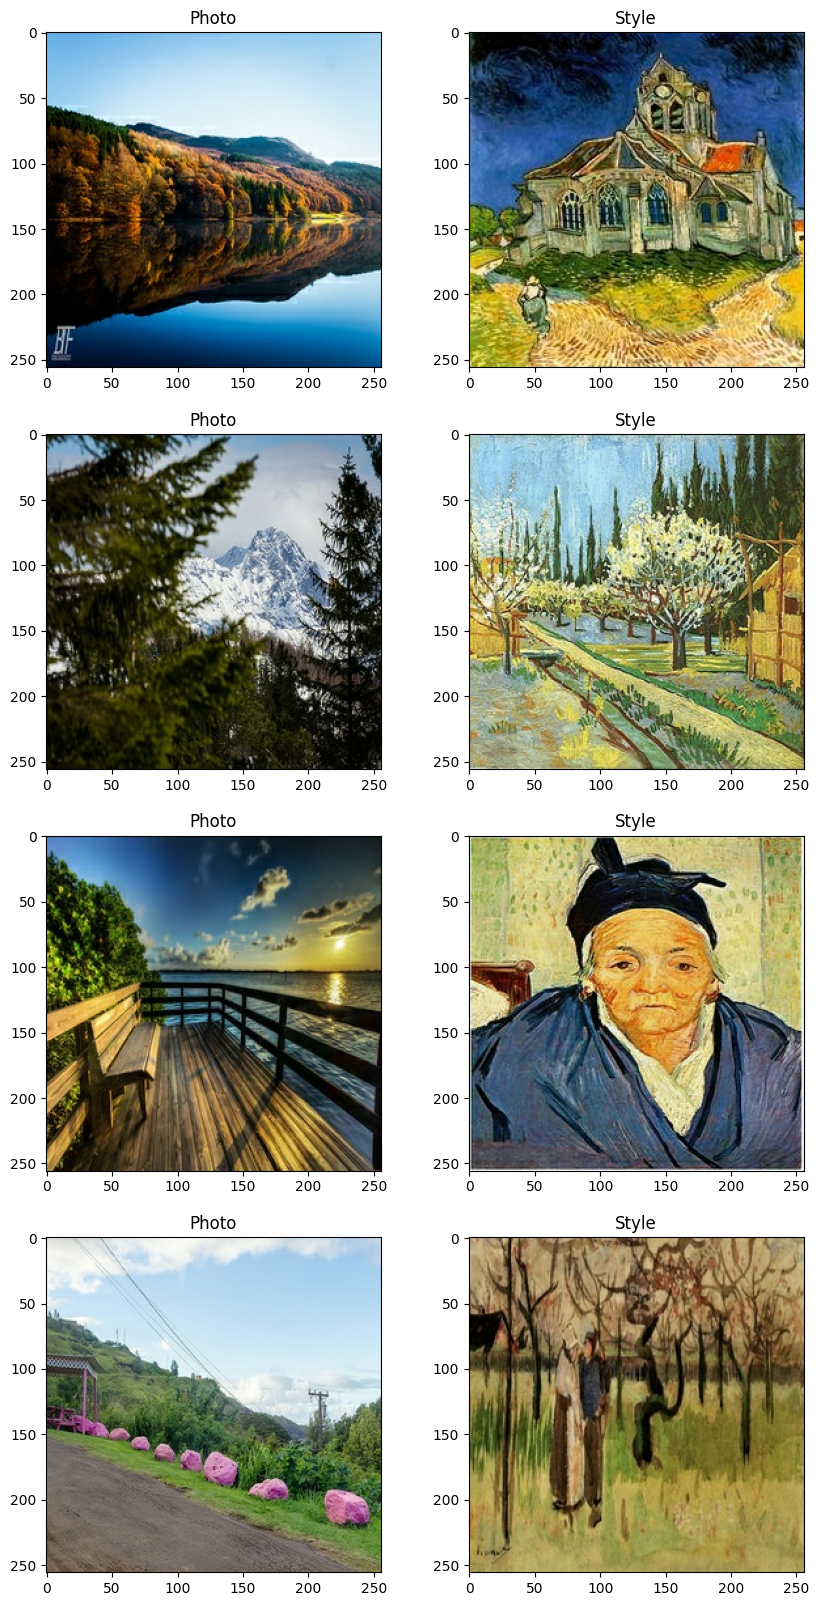

In [11]:
sample = dataset.as_numpy_iterator().next()

fig, axes = plt.subplots(4,2, figsize=(10,20))
for i in range(4):
    axes[i][0].imshow(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8))
    axes[i][0].set_title('Photo')
    axes[i][1].imshow(tf.cast(sample[1][i]*127.5+127.5, dtype=tf.uint8))
    axes[i][1].set_title('Style')

# MODEL

### Building the Model

In [12]:
class CycleGAN(Model):
    def __init__(self):
        super(CycleGAN, self).__init__()

        self.generatorP = self.build_generator()            # Generates Photo from kiyoe
        self.discriminatorP = self.build_discriminator()

        self.generatorU = self.build_generator()            # Generates Monet from Photo
        self.discriminatorU = self.build_discriminator()


    # Builds a Generator
    def build_generator(self):
        # Defines Residual Block
        def ResBlock(inputs):
            x = Conv2D(512, 4, 1, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(inputs)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = ReLU()(x)

            x = Conv2D(512, 4, 1, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)

            return Add()([x, inputs])

        # Downsampling block
        def ConvBlock(filters, kernel, strides, inputs):
            x = Conv2D(filters, kernel, strides, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(inputs)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = LeakyReLU()(x)
            return x

        # Upsampling block
        def TransConvBlock(filters, inputs):
            x = Conv2DTranspose(filters, 4, 2, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(inputs)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = ReLU()(x)
            return x

        # Generator
        input = Input(SHAPE)

        x = ConvBlock(64, 4, 2, input)
        y = ConvBlock(128, 4, 2, x)
        z = ConvBlock(256, 4, 2, y)
        c = ConvBlock(512, 4, 2, z)

        for _ in range(9):
            c = ResBlock(c)

        c = TransConvBlock(256, c)
        c = Concatenate()([z, c])
        c = TransConvBlock(128, c)
        c = Concatenate()([y, c])
        c = TransConvBlock(64, c)
        c = Concatenate()([x, c])
        c = TransConvBlock(64, c)

        out = Conv2D(3, 7, 1, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), activation='tanh')(c)

        return Model(inputs=input, outputs=out)


    # Builds a Discriminator
    def build_discriminator(self):
        def ConvBlock(filters, kernel, strides, normalize, inputs):
            x = Conv2D(filters, kernel, strides, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(inputs)
            if normalize:
                x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = LeakyReLU(0.2)(x)
            return x

        # Discriminator
        input = Input(shape=SHAPE)

        x = ConvBlock(64, 4, 2, False, input)
        x = ConvBlock(128, 4, 2, True, x)
        x = ConvBlock(256, 4, 2, True, x)
        x = ConvBlock(512, 4, 2, True, x)

        out = Conv2D(1, 4, 1, padding="same", activation='sigmoid')(x)

        return Model(inputs=input, outputs=out)


    def compile(self, genP_opt, discP_opt, genU_opt, discU_opt, gen_loss, cycle_loss, identity_loss, disc_loss):
        super().compile()
        self.genP_opt = genP_opt
        self.discP_opt = discP_opt
        self.genU_opt = genU_opt
        self.discU_opt = discU_opt
        self.gen_loss = gen_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss
        self.disc_loss = disc_loss


    # Custom train
    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            # Generators
            fakeU = self.generatorU(data[0], training=True)
            cycledP = self.generatorP(fakeU, training=True)

            fakeP = self.generatorP(data[1], training=True)
            cycledU = self.generatorU(fakeP, training=True)

            sameU = self.generatorU(data[1], training=True)
            sameP = self.generatorP(data[0], training=True)

            # Discriminators
            discU_real = self.discriminatorU(data[1], training=True)
            discP_real = self.discriminatorP(data[0], training=True)

            discU_fake = self.discriminatorU(fakeU, training=True)
            discP_fake = self.discriminatorP(fakeP, training=True)

            # Calculate losses
            discU_loss = self.disc_loss(discU_real, discU_fake)
            discP_loss = self.disc_loss(discP_real, discP_fake)
            disc_loss = discU_loss + discP_loss

            total_genU_loss = self.gen_loss(discU_fake) + self.cycle_loss(data[1], cycledU) + self.identity_loss(data[1], sameU)
            total_genP_loss = self.gen_loss(discP_fake) + self.cycle_loss(data[0], cycledP) + self.identity_loss(data[0], sameP)

            gen_loss = total_genU_loss + total_genP_loss

        # Calculate gradients
        discU_grads = tape.gradient(discU_loss, self.discriminatorU.trainable_variables)
        discP_grads = tape.gradient(discP_loss, self.discriminatorP.trainable_variables)

        genU_grads = tape.gradient(total_genU_loss, self.generatorU.trainable_variables)
        genP_grads = tape.gradient(total_genP_loss, self.generatorP.trainable_variables)

        # Optimize fuctions
        self.discU_opt.apply_gradients(zip(discU_grads, self.discriminatorU.trainable_variables))
        self.discP_opt.apply_gradients(zip(discP_grads, self.discriminatorP.trainable_variables))

        self.genU_opt.apply_gradients(zip(genU_grads, self.generatorU.trainable_variables))
        self.genP_opt.apply_gradients(zip(genP_grads, self.generatorP.trainable_variables))

        return {"total_loss":gen_loss+disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Custom test
    def test_step(self, data):
        fakeU = self.generatorU(data[0], training=False)
        cycledP = self.generatorP(fakeU, training=False)

        fakeP = self.generatorP(data[1], training=False)
        cycledU = self.generatorU(fakeP, training=False)

        sameU = self.generatorU(data[1], training=False)
        sameP = self.generatorP(data[0], training=False)

        # Discriminators
        discU_real = self.discriminatorU(data[1], training=False)
        discP_real = self.discriminatorP(data[0], training=False)

        discU_fake = self.discriminatorU(fakeU, training=False)
        discP_fake = self.discriminatorP(fakeP, training=False)

        # Calculate losses
        discU_loss = self.disc_loss(discU_real, discU_fake)
        discP_loss = self.disc_loss(discP_real, discP_fake)
        disc_loss = discU_loss+discP_loss

        total_genU_loss = self.gen_loss(discU_fake) + self.cycle_loss(data[1], cycledU) + self.identity_loss(data[1], sameU)
        total_genP_loss = self.gen_loss(discP_fake) + self.cycle_loss(data[0], cycledP) + self.identity_loss(data[0], sameP)

        gen_loss = total_genU_loss + total_genP_loss

        return {"total_loss":gen_loss+disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Save the Generator to convert Photo to Monet
    def save_generatorU(self, file_path):
        self.generatorU.save(file_path)

    # Save the Generator to convert Monet to Photo
    def save_generatorP(self, file_path):
        self.generatorP.save(file_path)

In [13]:
model = CycleGAN()
"""
model.generatorP.load_weights('drive/MyDrive/GeneratorP.h5')
model.generatorU.load_weights('drive/MyDrive/GeneratorU.h5')
model.discriminatorP.load_weights('drive/MyDrive/DiscriminatorP.h5')
model.discriminatorU.load_weights('drive/MyDrive/DiscriminatorU.h5')
"""
model.generatorP.summary()
model.discriminatorP.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         3136      ['input_1[0][0]']             
                                                                                                  
 instance_normalization (In  (None, 128, 128, 64)         128       ['conv2d[0][0]']              
 stanceNormalization)                                                                             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)         0         ['instance_normalization[0

### Loss and Optimizer Functions

In [14]:
# Optimizers
genP_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discP_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

genU_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discU_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

 # Discriminator loss
def disc_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return 0.5*total_loss


# Generator loss
def gen_loss(fake):
    return 1.0 * tf.reduce_mean(tf.keras.losses.MeanSquaredError()(tf.ones_like(fake), fake))

# Cycle loss
def cycle_loss(real_image, cycled_image):
    return 10.0 * tf.reduce_mean(tf.keras.losses.MeanSquaredError()(real_image, cycled_image))

# Identity loss
def identity_loss(real_image, same_image):
    return 0.1 * tf.reduce_mean(tf.keras.losses.MeanSquaredError()(real_image, same_image))

In [15]:
model.compile(genP_opt, discP_opt, genU_opt, discU_opt, gen_loss, cycle_loss, identity_loss, disc_loss)

### Training the Model

In [16]:
model.fit(dataset, epochs=2)        # 0 --> 2

Epoch 1/2
1550/1550 [==============================] - 2995s 2s/step - total_loss: 4.1430 - gen_loss: 3.2090 - disc_loss: 0.9339
Epoch 2/2
1550/1550 [==============================] - 2896s 2s/step - total_loss: 3.4060 - gen_loss: 2.2363 - disc_loss: 1.1697


In [17]:
model.generatorP.save_weights('drive/MyDrive/GeneratorP.h5')
model.generatorU.save_weights('drive/MyDrive/GeneratorU.h5')
model.discriminatorP.save_weights('drive/MyDrive/DiscriminatorP.h5')
model.discriminatorU.save_weights('drive/MyDrive/DiscriminatorU.h5')

### Testing the Model

In [18]:
iter = dataset.as_numpy_iterator()

In [21]:
sample = iter.next()

#### Photo to Style

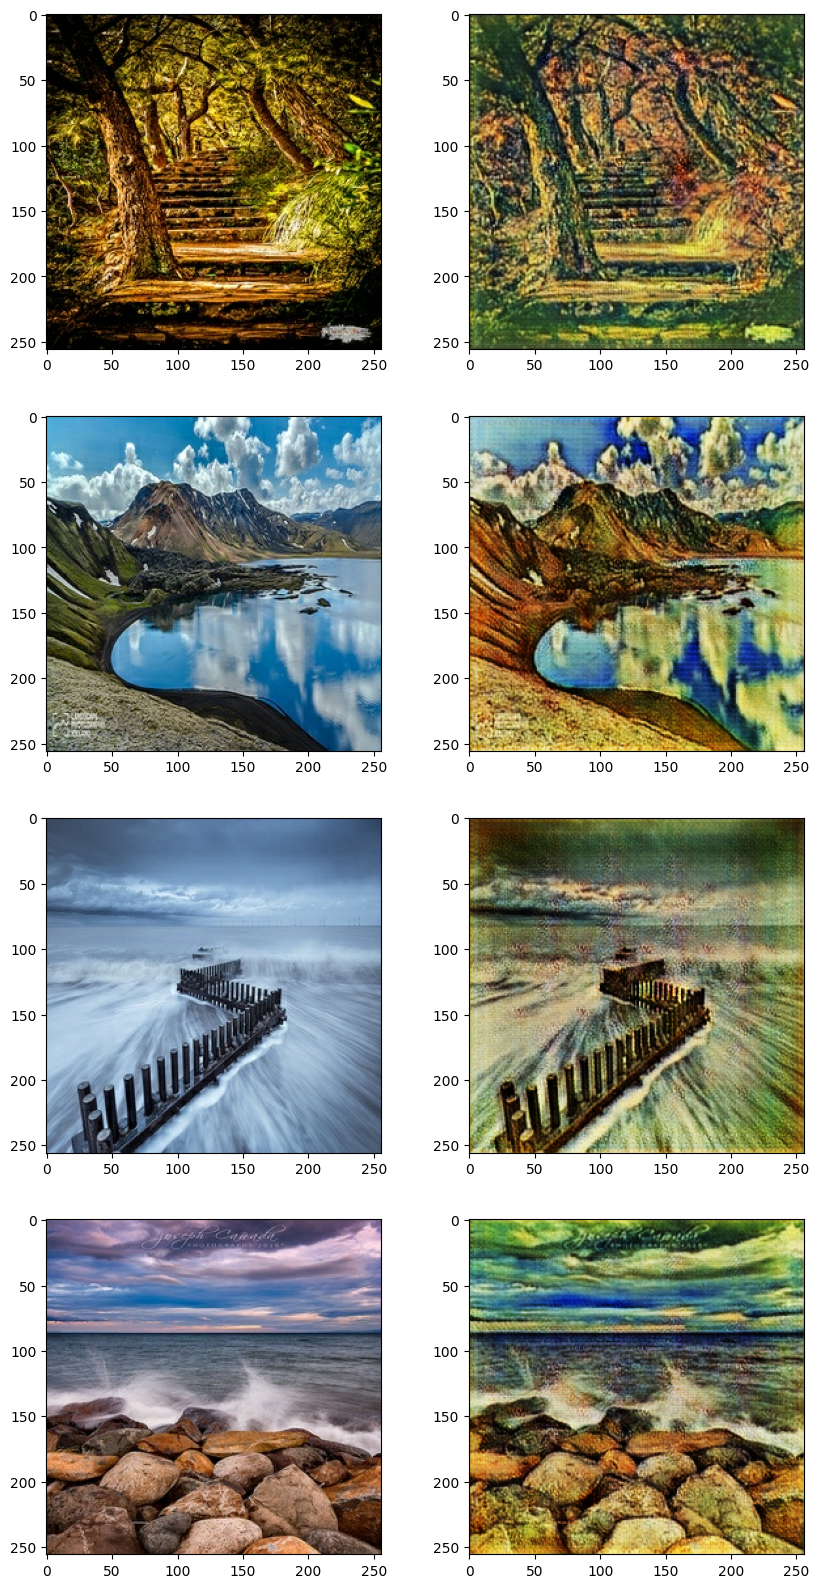

In [22]:
generated = model.generatorU(sample[0])

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axes[i][0].imshow(np.squeeze(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8)))
    axes[i][1].imshow(np.squeeze(tf.cast(generated[i]*127.5+127.5, dtype=tf.uint8)))

#### Style to Photo

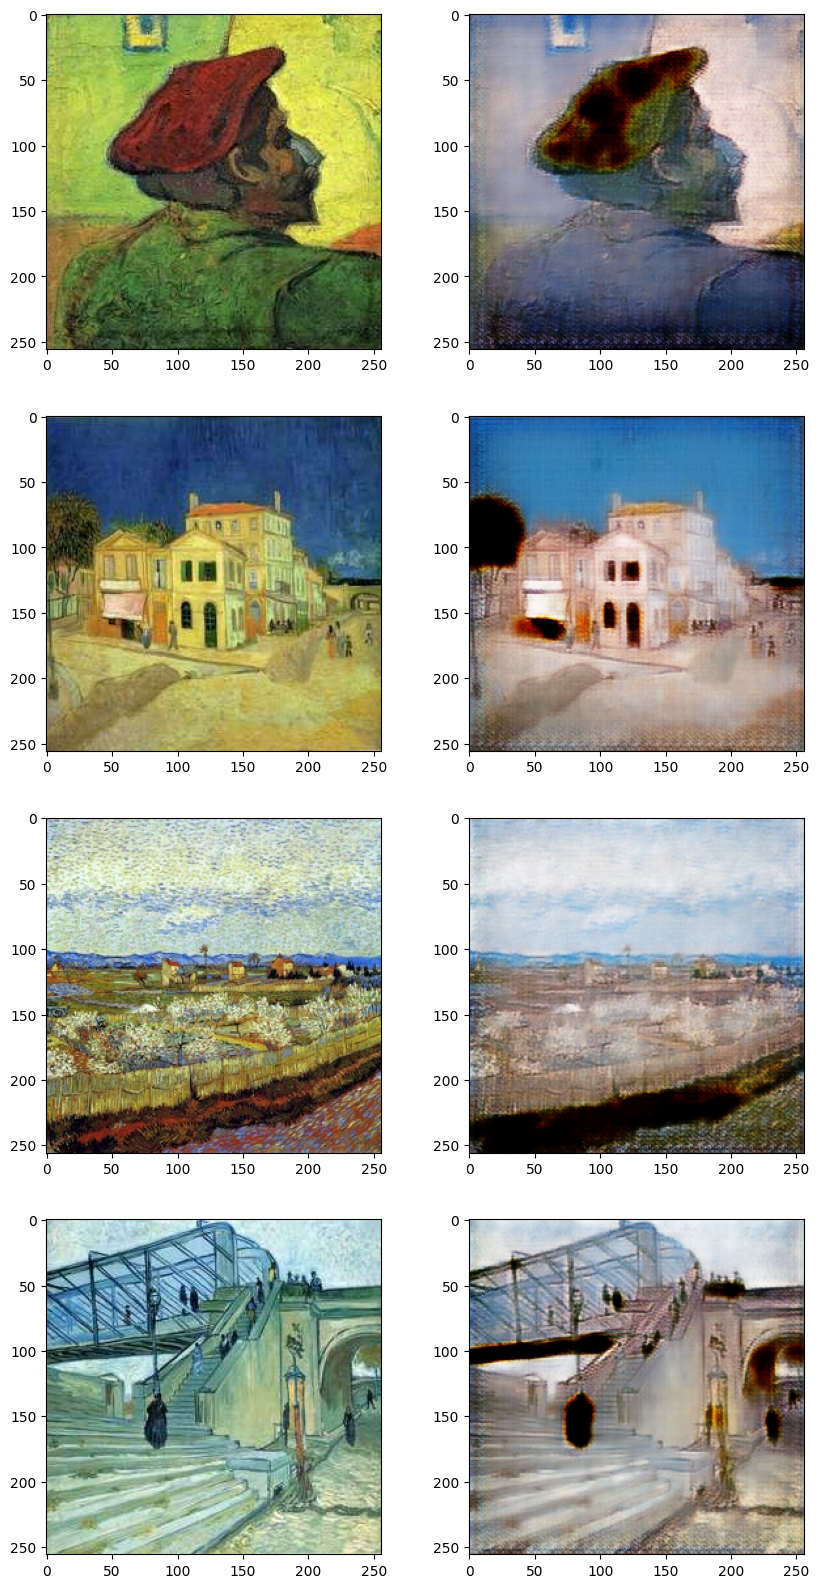

In [23]:
generated = model.generatorP(sample[1])

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axes[i][0].imshow(np.squeeze(tf.cast(sample[1][i]*127.5+127.5, dtype=tf.uint8)))
    axes[i][1].imshow(np.squeeze(tf.cast(generated[i]*127.5+127.5, dtype=tf.uint8)))

### Saving the Generators

In [ ]:
model.save_generatorU('2.CycleGAN_U.h5')
model.save_generatorP('2.CycleGAN_P.h5')